# Opnieuw uitvoeren van paar maand terug
 => EDIT 3-1-2019: fout verbeterd (nperseg ipv nfft in sig.spectrogram)

In [1]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from contextlib import redirect_stdout

from util import util
from util import WavFileParts
from util.logUtil import LOG, LOG_HEADER
from util.confusionMatrix import ConfusionMatrix


Using TensorFlow backend.


# Centrale parameter: NFFT

In [2]:
NFFT = 4096

### globale settings

In [3]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir
recordingDir = osDir + '/localizationRecordings'

if osDir == winDir:
    storageFolder = 'E:/SAA_DATA/storedData/'
else:
    storageFolder = '/Users/etto/Desktop/storedData/'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

orgsG428 = ['G428_0.0_1.4','G428_2.1_2.4']
orgsG527 = ['G527_0.5_1.4','G527_1.2_5.8']
orgsStudio = ['Studio_2.0_4.2','Studio_3.0_2.0']

chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [4]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allSpectros, allClasses, storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    df = pd.DataFrame(allSpectros)
    df.to_hdf(path_or_buf=filename, key='spectros_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    specDf = pd.read_hdf(path_or_buf=filename, key='spectros_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return specDf.values, classesDf.values
    

### functies tbv trainen

In [5]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

def getFilesPerCatFromMultipleDirs(srcDirs, srcDirsBase=''):
    filesPerCat = {}
    for dirName in srcDirs:
        srcDir = srcDirsBase + '/' + dirName
        fpcNw = getFilesPerCategory(srcDir)
        if not filesPerCat:
            filesPerCat = fpcNw
        else:
            for key in filesPerCat:
                filesPerCat[key] += fpcNw[key]
    return filesPerCat
        

In [6]:
# Maakt een dictionary aan; per categorie de spectrogrammen
def getSpectrosFromFilesPerCategory(filesPerCategory, NFFT):
    spectros = {}
    for clz in classes:
        spectros[clz] = []
        for filename in filesPerCategory[clz]:
            fs, signal = wv.read(filename)
            freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nperseg=NFFT, noverlap=0)
            spectros[clz].append(spectrogram.T)
    return spectros

In [7]:
def getClassLengths(spectrosPerCat):
    clzLengths = {}
    for clz in classes:
        clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectrosPerCat[clz]])
    return clzLengths

In [8]:
# verwacht invoer van getSpectrosFromFilesPerCategory
# levert traindata op (X_train en Y_train)
def createTrainDataFromSpectros(spectrosPerCat, clzLengths):
    X_train = np.concatenate(spectrosPerCat[classes[0]], axis=0)
    for i in range(1, len(classes)):
        nwSpectros = np.concatenate(spectrosPerCat[classes[i]], axis=0)
        X_train = np.concatenate((X_train,nwSpectros), axis=0)
    
    # one-hot encoding voor Y_train
    nrFiles = clzLengths[classes[0]]
    Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

    nrFiles = clzLengths[classes[1]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.ones(nrFiles), np.zeros(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

    nrFiles = clzLengths[classes[2]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.zeros(nrFiles), np.ones(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
    
    return X_train, Y_train

### deep learning model

In [9]:
def create_model(layersizes, NFFT):
    # create model
    model = Sequential()
    model.add(Dense(layersizes[0], input_dim=(int(NFFT/2+1)), activation='relu'))
    for lsize in layersizes[1:]:
        model.add(Dense(lsize, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
def getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs):
    modelFilename = modelFilePath + baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    modelFilename += '.hd5'
    return modelFilename

In [11]:
def getModelName(baseModelFilename, layers, nrEpochs):
    modelFilename = baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    return modelFilename

In [12]:
def train_model(X_train, Y_train, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()

In [13]:
def train_and_evaluate_model(X_train, Y_train, realTrainClasses, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()
    evaluate_model(X_train, realTrainClasses,layers, nrEpochs, modelFilePath, baseModelFilename)

In [14]:
def evaluate_model(X_test, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = load_model(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))

    # predicted classes
    predictions = soundModel.predict(X_test)
    predClasses = predictions.argmax(axis=1)

    matrix = ConfusionMatrix(classes)
    for vals in zip(realClasses, predClasses):
        matrix.add(int(vals[0]), int(vals[1]), 1)
    LOG(matrix.toString(),True)
    LOG('', True)
    LOG(matrix.toF1String(), True)
    return matrix

In [15]:
def train_and_evaluate_per_epoch(X_train, Y_train, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename, NFFT, batch_size=None):
    soundModel = create_model(layers, NFFT)
    for epNr in range(1, nrEpochs+1):
        LOG('\n*****************\n* Epoch nr {}\n*****************\n'.format(epNr), True)
        soundModel.fit(X_train,Y_train, epochs=1, shuffle=True, verbose=1, batch_size=batch_size)
        soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, epNr))
        evaluate_model(X_train, realClasses, layers, epNr, modelFilePath, baseModelFilename)

### functies tbv testen

In [16]:
def createAndStoreTestData(wavFileParts, baseDir, fileDate, micNr, storeFilename, NFFT, keyName):
    allSpectros = np.array([])
    allClasses = np.array([])

    for wfPt in wavFileParts: #type: WavFilePart
        if not 'Gunshot' in wfPt.getSoundType():
            filename = baseDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wfPt.fileNr, micNr)
            fs, signal = wv.read(filename)

            classNr = classes.index(wfPt.getSoundType().lower())
            for soundChunk in wfPt.getSoundChunks(micNr):
                startFrame = int(soundChunk[0] * fs)
                endFrame = int(soundChunk[1] * fs)

                sigChunk = signal[startFrame: endFrame]
                freq_array, segment_times, spectrogram = sig.spectrogram(x=sigChunk, fs=fs, nperseg=NFFT, noverlap=0)
                if len(allSpectros) == 0:
                    allSpectros = spectrogram.T
                else:
                    allSpectros = np.append(allSpectros, spectrogram.T, axis=0)
                allClasses = np.append(allClasses, classNr * np.ones(len(segment_times)))       
    storeTestData(allSpectros, allClasses, storeFilename, NFFT, keyName)


In [17]:
def getTrainDataFromFolders(orgWavDirs, NFFT):
    fpc = getFilesPerCatFromMultipleDirs(orgWavDirs, baseSrcDir)
    spcs = getSpectrosFromFilesPerCategory(fpc, NFFT)
    clzLengths = getClassLengths(spcs)
    X_train, Y_train = createTrainDataFromSpectros(spcs, clzLengths)
    # real train classes
    realTrainClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                                  np.ones(clzLengths[classes[1]]), 
                                  2*np.ones(clzLengths[classes[2]])))
    return X_train, Y_train, realTrainClasses


In [18]:
def testModellen(modelFilePath, layerss, NFFT, micNr, testFileNames, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    for layers in layerss:
        for nrEpochs in nrsEpochs:
            overallMatrix = ConfusionMatrix(classes)
            for testFileName in testFileNames:
                testSpecs, testClasses = retrieveTestData(testFileName, NFFT, keyname)

                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + testFileName,
                           True)
                matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
                overallMatrix.addMatrix(matrix.normalizedCopy())
            
            if showOverall:
                overallMatrix = overallMatrix.normalizedCopy()
                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + 'testData_Overall',
                           True)
                LOG(overallMatrix.toString(),True)
                LOG('', True)
                LOG(overallMatrix.toF1String(), True)

In [19]:
def testModel(modelFilePath, layers, micNr, testFileNames, nrEpochs, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    overallMatrix = ConfusionMatrix(classes)
    for testFileName in testFileNames:
        testSpecs, testClasses = retrieveTestData(testFileName, keyname)

        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + testFileName,
                   True)
        matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
        overallMatrix.addMatrix(matrix.normalizedCopy())

    if showOverall:
        overallMatrix = overallMatrix.normalizedCopy()
        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + 'testData_Overall',
                   True)
        LOG(overallMatrix.toString(),True)
        LOG('', True)
        LOG(overallMatrix.toF1String(), True)

### trainen van model obv: alles G428, G527 en Studio

In [20]:
# Train voor alle lagen
baseModelFilename = '20190103_NFFT{}'.format(NFFT)
modelFilePath = storageFolder
logPrefix = 'Alle orgs'
orgWavDirs = orgsG428 + orgsG527 + orgsStudio


In [21]:
X_train, Y_train, realTrainClasses = getTrainDataFromFolders(orgWavDirs, NFFT)

In [22]:
# Maak test data
LOG_HEADER('maak spectra voor testdata G428, NFFT={}'.format(NFFT), True)
wvPts = readSoundChunksDynamic('chunks.G428.soundChunks')
baseDir = recordingDir + '/20170221'
fileDate = 170221
filename = 'testData_G428'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, NFFT, keyname)

LOG('Klaar: spectra voor testdata G428', True)

####################################
#
# maak spectra voor testdata G428, NFFT=4096
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: spectra voor testdata G428


In [23]:
# Maak test data
LOG_HEADER('maak spectra voor testdata G527, NFFT={}'.format(NFFT), True)
wvPts = readSoundChunksDynamic('chunks.G527.soundChunks')
baseDir = recordingDir + '/20170221'
fileDate = 170221
filename = 'testData_G527'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, NFFT, keyname)

LOG('Klaar: spectra voor testdata G527', True)

####################################
#
# maak spectra voor testdata G527, NFFT=4096
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: spectra voor testdata G527


In [24]:
LOG_HEADER('maak spectra voor testdata Studio, NFFT={}'.format(NFFT), True)
wvPts = readSoundChunksDynamic('chunks.Studio.soundChunks')
baseDir = recordingDir + '/20171011'
fileDate = 170816
filename = 'testData_Studio'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, NFFT, keyname)

LOG('Klaar: spectra voor testdata Studio', True)

####################################
#
# maak spectra voor testdata Studio, NFFT=4096
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: spectra voor testdata Studio


In [25]:
layersList = [[100, 20], [400, 250, 100, 20], [400, 300, 200, 100, 50, 20, 10], 
              [450, 400, 350, 300, 250, 200, 150, 100, 50, 21]]
nrEpochs = 5
nrsEpochs = range(1, nrEpochs + 1)
#nrsEpochs = [nrEpochs]
bSize = 128

In [26]:
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_per_epoch(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename, NFFT,
                                batch_size=bSize)

####################################
#
# Alle orgs, lagen: [100, 20]
#
####################################


*****************
* Epoch nr 1
*****************

Epoch 1/1
69229/69229 [==============================] - 6s 82us/step - loss: 0.3417 - acc: 0.8833
                   m       v       e |  sens   acc
music          21066    1798      31 |  0.92  0.97
voice            248   22162     499 |  0.97  0.93
environment       32    2415   20978 |  0.90  0.96
--------------------------------------
prec            0.99    0.84    0.98

F1 overall: 0.93
F1 music: 0.95
F1 voice: 0.90
F1 environment: 0.93


*****************
* Epoch nr 2
*****************

Epoch 1/1
69229/69229 [==============================] - 4s 54us/step - loss: 0.1726 - acc: 0.9402
                   m       v       e |  sens   acc
music          21974     911      10 |  0.96  0.98
voice            442   22025     442 |  0.96  0.95
environment       41    1553   21831 |  0.93  0.97
-------------------------------------

69229/69229 [==============================] - 8s 109us/step - loss: 0.0694 - acc: 0.9773
                   m       v       e |  sens   acc
music          22539     342      14 |  0.98  0.99
voice            233   22340     336 |  0.98  0.98
environment        7     213   23205 |  0.99  0.99
--------------------------------------
prec            0.99    0.98    0.99

F1 overall: 0.98
F1 music: 0.99
F1 voice: 0.98
F1 environment: 0.99


*****************
* Epoch nr 3
*****************

Epoch 1/1
69229/69229 [==============================] - 7s 105us/step - loss: 0.0624 - acc: 0.9807
                   m       v       e |  sens   acc
music          22705     183       7 |  0.99  0.99
voice            299   22352     258 |  0.98  0.99
environment        8     269   23148 |  0.99  0.99
--------------------------------------
prec            0.99    0.98    0.99

F1 overall: 0.99
F1 music: 0.99
F1 voice: 0.98
F1 environment: 0.99


*****************
* Epoch nr 4
*****************

Epoch 1/

In [27]:
# Test alle modellen
fileName='plots/20190103_NFFT{}.txt'.format(NFFT)
with open(fileName, 'w') as f:
    with redirect_stdout(f):       
        testModellen(modelFilePath=storageFolder, 
                     layerss=layersList, 
                     NFFT=NFFT,
                     micNr=4, 
                     testFileNames=['testData_G428', 'testData_G527', 'testData_Studio'], 
                     showOverall=True)                

In [28]:
from parseExperimentResults import parseRedoExperiment

creating plots in plots/20190103_NFFT4096/


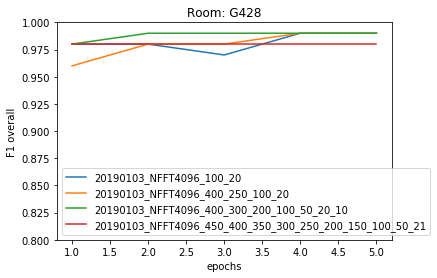

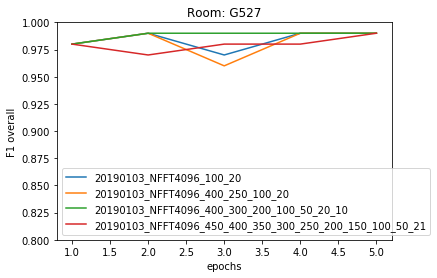

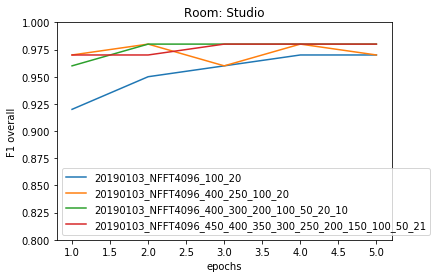

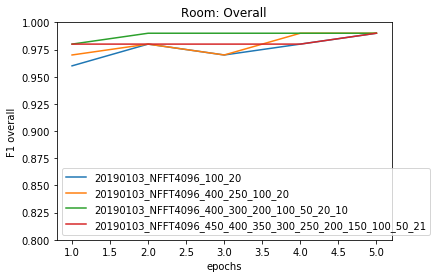

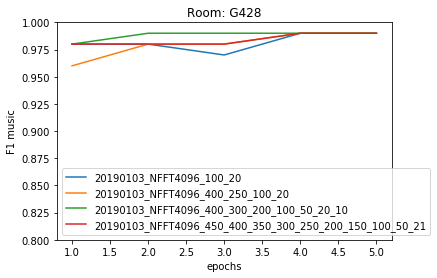

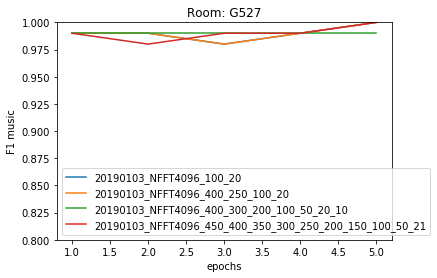

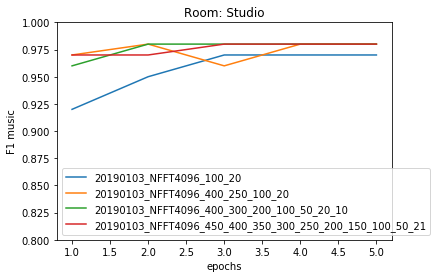

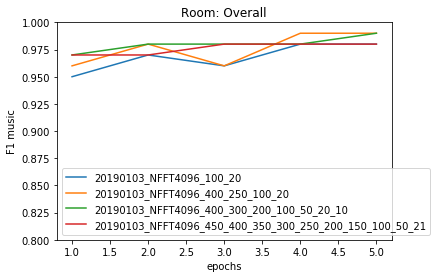

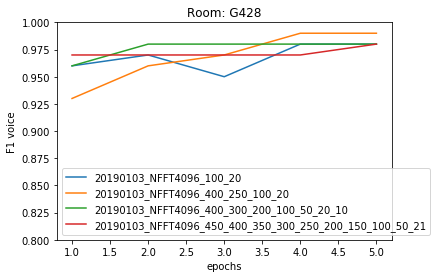

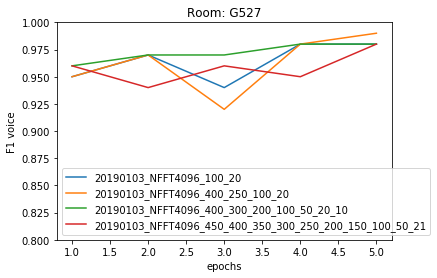

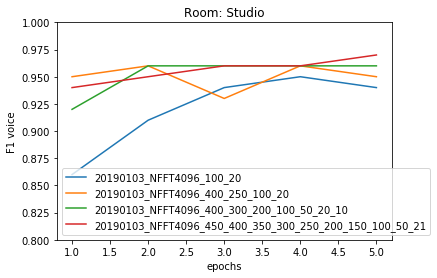

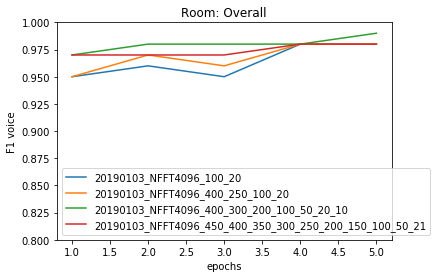

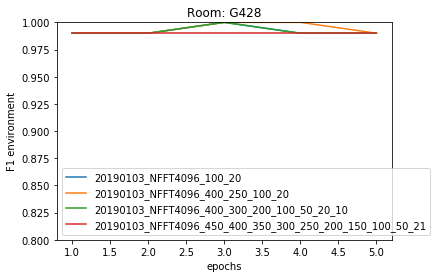

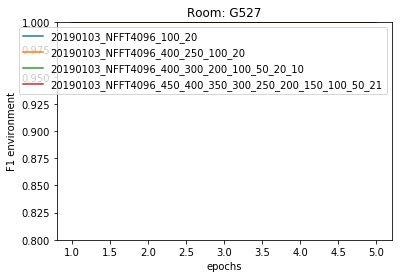

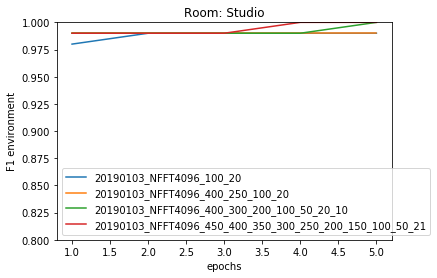

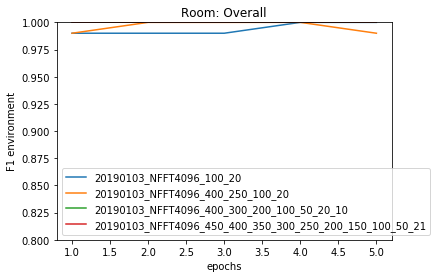

In [29]:
experimentId='20190103_NFFT{}'.format(NFFT)
filePattern='20190103_NFFT{}'.format(NFFT)
parseRedoExperiment(experimentId, filePattern)